In [1]:
import glob
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi
from matplotlib.patches import Rectangle, Circle

In [2]:
np.random.seed(174612)

# read data

In [3]:
filesMicro = glob.glob('../../microarray_GSE39615/mass_signal_convertedgenes.tsv')

In [4]:
dfmicro = read_csv(filesMicro[0], sep = '\t')
xdfmicro = dfmicro.groupby('gene').aggregate(lambda x: sum(x)/len(x))
psmcols1 = [col for col in dfmicro.columns if 'Pre Somitic Mesoderm' in col and 'rep1' in col]
psmcols2 = [col for col in dfmicro.columns if 'Pre Somitic Mesoderm' in col and 'rep2' in col]
psmcols3 = [col for col in dfmicro.columns if 'Pre Somitic Mesoderm' in col and 'rep3' in col]
ntcols1 = [col for col in dfmicro.columns if 'Neural Tube' in col and 'rep1' in col]
ntcols2 = [col for col in dfmicro.columns if 'Neural Tube' in col and 'rep2' in col]
dfspsm = [xdfmicro[psmcols1[::-1]], xdfmicro[psmcols2[::-1]], xdfmicro[psmcols3[::-1]]]
dfsnt = [xdfmicro[ntcols1[::-1]], xdfmicro[ntcols2[::-1]]]

# Select genes present in all samples for each timepont

In [5]:
def findUbiGenes(dfs):
    genes = []
    for df in dfs:
        genes += list(df.loc[df.sum(axis=1)>0].index)
    cnt = Counter(genes)
    gs = [g for g in cnt if cnt[g]==len(dfs)]
    print(len(cnt), len(gs))
    return gs

In [6]:
gPSM = findUbiGenes(dfspsm)
gNT = findUbiGenes(dfsnt)

20693 20693
20693 20693


# number of reads and genes per section

### PSM

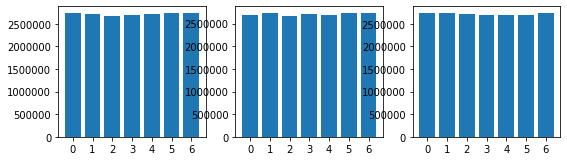

In [8]:
plt.figure(figsize=(3*len(dfspsm),2.4))
for i, df in enumerate(dfspsm):
    plt.subplot(1,len(dfspsm),i+1)
    cnt = df.sum()
    plt.bar(cnt.keys(), cnt)
#    plt.yscale('log')
    plt.xticks(range(len(df.columns)), range(len(df.columns)))
plt.show()

### NT

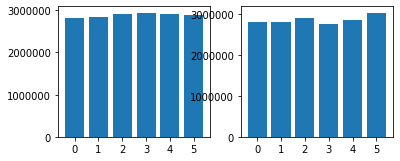

In [9]:
plt.figure(figsize=(3*len(dfsnt),2.4))
for i, df in enumerate(dfsnt):
    plt.subplot(1,len(dfsnt),i+1)
    cnt = df.sum()
    plt.bar(cnt.keys(), cnt)
#    plt.yscale('log')
    plt.xticks(range(len(df.columns)), range(len(df.columns)))

plt.show()

# normalize and prepare data, the same way as always

In [10]:
def removeGenes(df):
    genes = ['ERCC','chrM', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    g = []
    for idx in df.index:
        if 'Gm' in idx:
            gid = idx.rsplit('Gm')[1].rsplit('__')[0]
            if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
                g.append(idx)
    return df.loc[[idx for idx in df.index if idx not in g]]

In [11]:
def filter_norm_dfs(dfs):
#     fdfs = [removeGmGenes(removeGenes(df)) for df in dfs]
    fdfs = [removeGenes(df) for df in dfs]
    fdfs = [df.loc[df.index[df.sum(axis=1)>0]] for df in fdfs]
    nfdfs = [df.sum().mean()*df/df.sum() for df in fdfs]
    return nfdfs

nfdfsPSM = filter_norm_dfs(dfspsm)
nfdfsNT = filter_norm_dfs(dfsnt)

In [12]:
for i, df in enumerate(nfdfsPSM):
    df.to_csv('../PSM-'+str(i+1) + '.microarray.tsv', sep = '\t')

In [14]:
ls ../PSM*

../PSM-1.microarray.tsv  ../PSM-2.microarray.tsv  ../PSM-3.microarray.tsv
../PSM-1.zscore.tsv      ../PSM-2.zscore.tsv      ../PSM-3.zscore.tsv


In [25]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [26]:
znfdfsPSM = [zscore(df) for df in nfdfsPSM]
znfdfsNT = [zscore(df) for df in nfdfsNT]

sznfdfsPSM = [scalezscore(df) for df in znfdfsPSM]
sznfdfsNT = [scalezscore(df) for df in znfdfsNT]

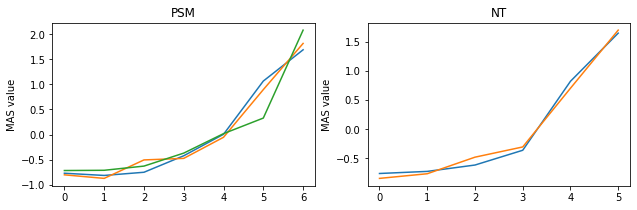

In [27]:
plt.figure(figsize=(16,3))
plt.subplot(132)
for df in znfdfsPSM:
    plt.plot(range(len(df.columns)), df.loc['T'])
plt.title('PSM')
plt.ylabel('MAS value')
plt.subplot(133)
for df in znfdfsNT:
    plt.plot(range(len(df.columns)), df.loc['T'])
plt.title('NT')
plt.ylabel('MAS value')
#
#plt.savefig(path + 'geneT.pdf', bbox_inches = 'tight')
plt.show()

# average PSM and average NT

In [28]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [29]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set([c.rsplit()[-1] for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == c.rsplit()[-1]]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<=mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

In [30]:
avPSM = averageGastruloid(mergeDfs(znfdfsPSM), 7)
avNT = averageGastruloid(mergeDfs(znfdfsNT), 6)

In [31]:
avPSM.to_csv('../averagePSM_zscores.tsv', sep = '\t')

In [32]:
for i, df in enumerate(znfdfsPSM):
    df.to_csv('../PSM-'+str(i+1) + '.zscore.tsv', sep = '\t')

# Identify reproducible genes in each timepoint

## Background model

In [19]:
def simulationCorrelations(n1, n2, N = 5000):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    psdf = pd.DataFrame({'corr': sorted(ps), 'cum': np.linspace(0,1, N)})
    psdf['pval'] = 1.-psdf['cum']
    return psdf

## Correlation between genes

In [20]:
def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [21]:
def assignPval2corr(cdf, pdf, corrcolname = 'corr'):
    cdf2 = pd.DataFrame(cdf, columns = [corrcolname])
    cdf2['pv'] = 0
    for g in cdf.index:
        pv = cdf.loc[g]
        if (pdf['corr'] >= pv).sum() > 0:
            p0 = pdf[pdf['corr'] >= pv].iloc[0]['pval']
        else:
            p0 = 0.
        if (pdf['corr'] <pv).sum() > 0:
            p1 = pdf[pdf['corr'] < pv].iloc[-1]['pval']
        else:
            p1 = 1.
        cdf2.loc[g,'pv'] = 0.5*(p0+p1)
    cdf2['adj-pv'] = multi.fdrcorrection(cdf2['pv'],  method='indep')[1]
    return cdf2      

In [22]:
def mergeGeneLists(gene_list):
    for x in gene_list:
        gene_list[x].columns = [str(c) + '_' + str(x) for c in gene_list[x].columns]
    ks = list(gene_list.keys())
    mdf = gene_list[ks[0]]
    for i in range(1,len(ks)):
        mdf = mdf.merge(gene_list[ks[i]], how = 'inner', left_index = True, right_index = True)
    return mdf

In [23]:
pv_sim_PSM = {}
corrGenes_PSM = {}
for x, (i1, i2) in enumerate(it.combinations(range(len(znfdfsPSM)), 2)):
    pv_sim_PSM[(i1, i2)] = simulationCorrelations(n1 = len(znfdfsPSM[i1].columns), n2 = len(znfdfsPSM[i2].columns))
    corrGenes_PSM[(i1, i2)] = geneCorrelation(znfdfsPSM[i1], znfdfsPSM[i2])
    corrGenes_PSM[(i1, i2)] = assignPval2corr(corrGenes_PSM[(i1, i2)], pv_sim_PSM[(i1,i2)])
mdfPSM = mergeGeneLists(corrGenes_PSM)

In [24]:
pv_sim_NT = {}
corrGenes_NT = {}
for x, (i1, i2) in enumerate(it.combinations(range(len(znfdfsNT)), 2)):
    pv_sim_NT[(i1, i2)] = simulationCorrelations(n1 = len(znfdfsNT[i1].columns), n2 = len(znfdfsNT[i2].columns))
    corrGenes_NT[(i1, i2)] = geneCorrelation(znfdfsNT[i1], znfdfsNT[i2])
    corrGenes_NT[(i1, i2)] = assignPval2corr(corrGenes_NT[(i1, i2)], pv_sim_NT[(i1,i2)])
mdfNT = mergeGeneLists(corrGenes_NT)

In [25]:
mdfPSM.to_csv('../results_postRevJan19/geneCorrelations_PSM.tsv', sep = '\t')
mdfNT.to_csv('../results_postRevJan19/geneCorrelations_NT.tsv', sep = '\t')

# Gene selection for each sample

## PSM

In [26]:
mdfPSM.loc[mdfPSM[['pv_(0, 1)','pv_(0, 2)','pv_(1, 2)']].mean(axis=1).sort_values().index].head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(1, 2)","pv_(1, 2)","adj-pv_(1, 2)"
Wnt3a,0.993264,0.0,0.0,0.989378,0.0,0.0,0.989813,0.0,0.0
Trps1,0.982351,0.0,0.0,0.992127,0.0,0.0,0.983642,0.0,0.0
Endod1,0.984139,0.0,0.0,0.986912,0.0,0.0,0.988940,0.0,0.0
Pgm5,0.982396,0.0,0.0,0.997002,0.0,0.0,0.987796,0.0,0.0
Gli2,0.982934,0.0,0.0,0.997155,0.0,0.0,0.978479,0.0,0.0


In [27]:
pvth = 0.1; nth = 3
pvcols = [c for c in mdfPSM.columns if 'pv_('==c[:4]]
gl_PSM = mdfPSM.index[mdfPSM.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

## NT

In [28]:
mdfNT.loc[mdfNT[['pv_(0, 1)']].mean(axis=1).sort_values().index].head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)"
Ccnd2,0.975718,0.0,0.0
Adamts20,0.989662,0.0,0.0
Mnx1,0.996976,0.0,0.0
Adamtsl2,0.969764,0.0,0.0
Rell1,0.996103,0.0,0.0


In [29]:
pvth = 0.05; nth = 1
pvcols = [c for c in mdfNT.columns if 'pv_('==c[:4]]
gl_NT = mdfNT.index[mdfNT.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [30]:
len(gl_PSM), len(gl_NT)

(1989, 2755)

# check reproducibility

In [31]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2','Nkx1-2','Cyp26a1', 'Foxb1', 'Ets2',
            'Hes3','Pax6','Irx3','Irx5','Sox21','Dbx1','Dll1','Meox1','Tcf15','Pax3','Ptn','Klf3','Spon1', 'Rab3il1',
          'Mesp2','Ripply2','Dppa5a','Meox1','Tbx6','T', 'Hand1', 'Hand2', 'Gata6', 'Mef2c']

In [32]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [33]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [34]:
zmdfPSM = mergeDfs(znfdfsPSM)
zmdfNT = mergeDfs(znfdfsNT)

In [35]:
zmdfPSM.to_csv('../results_postRevJan19/merge_zscore_PSM.tsv', sep = '\t')
zmdfNT.to_csv('../results_postRevJan19/merge_zscore_NT.tsv', sep = '\t')

In [36]:
nmdfPSM = mergeDfs(nfdfsPSM)
nmdfNT = mergeDfs(nfdfsNT)

In [37]:
nmdfPSM.to_csv('../results_postRevJan19/merge_norm_PSM.tsv', sep = '\t')
nmdfNT.to_csv('../results_postRevJan19/merge_norm_NT.tsv', sep = '\t')

## PSM

In [38]:
len(gl_PSM), 5*np.sqrt(len(gl_PSM))

(1989, 222.9910312097776)

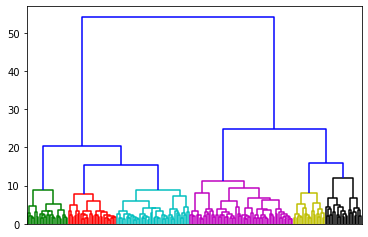

In [39]:
somhcl_PSM_df = comboCluster(zmdfPSM, gl_PSM, cth=12, gridheight=22, gridwidth=10)

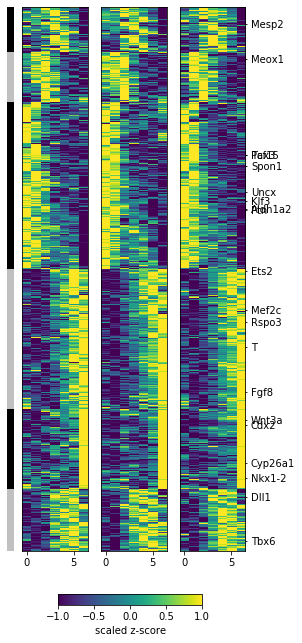

In [40]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_PSM_df
dfs = znfdfsPSM
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g in g_annotate])
ax[-1].set_yticklabels([g for g in gene_order[::-1] if g in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -3*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n
    
plt.savefig('../results_postRevJan19/heatmap_microarray_PSM_reprGenes.pdf', bbox_inches = 'tight')
somhcl_PSM_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/clusters_microarray_PSM_reprGenes.tsv', sep = '\t')

plt.show()

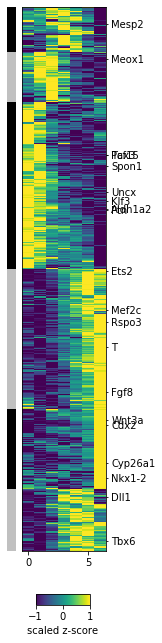

In [41]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (1.5,10))

hcl = somhcl_PSM_df
df = avPSM.astype(float)
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ax.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
ax.set_yticks([])
ax.tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax.set_yticks([i for i, g in enumerate(gene_order[::-1]) if g in g_annotate])
ax.set_yticklabels([g for g in gene_order[::-1] if g in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im, label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(df.columns)
x0 = -2.5*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax.add_patch(rect)
    y0 -= n

plt.savefig('../results_postRevJan19/heatmap_microarray_PSM_reprGenes_average.pdf', bbox_inches = 'tight')

plt.show()

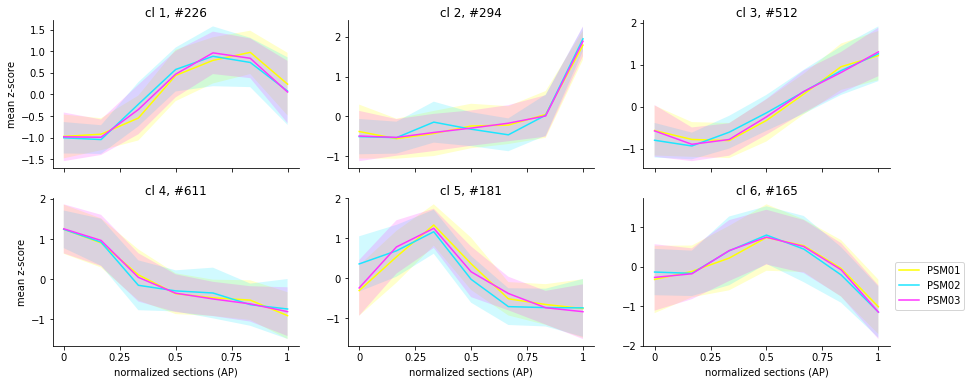

In [45]:
fig = plt.figure(figsize=(15,6))

for cl in set(somhcl_PSM_df['hcl']):
    ax = fig.add_subplot(2,3,cl+1)
    genes = somhcl_PSM_df[somhcl_PSM_df['hcl']==cl].index
    for i, df in enumerate(znfdfsPSM):
        xra = np.linspace(0,1,len(df.columns))
        
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i], interpolate=True, alpha = 0.2)
        
    ax.set_title('cl '+str(cl+1)+', #'+str(len(genes)), pad = -100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,0.25,0.50,0.75,1]); ax.set_xticklabels([])

    if cl+1 in [1,4]:
        ax.set_ylabel('mean z-score')
    if cl+1 >= 4:
        plt.xlabel('normalized sections (AP)')
        ax.set_xticklabels([0,0.25,0.50,0.75,1])
        
plt.legend(['PSM01', 'PSM02', 'PSM03'], loc = 2, bbox_to_anchor = (1,0.6))
plt.savefig('../results_postRevJan19/lineplots_microarray_PSM_reprGenes_average.pdf', bbox_inches = 'tight')
plt.show()

## NT

In [ ]:
somhcl_NT_df = comboCluster(zmdfNT, gl_NT, cth=12)

In [ ]:
plt.figure(figsize=(10,10))

gene_order = somhcl_NT_df.sort_values(by=['hcl','som']).index
Npl = len(znfdfsNT)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_NT_df['hcl']):
    y = 1.0*len(somhcl_NT_df[somhcl_NT_df['hcl'] == i])/len(somhcl_NT_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(sznfdfsNT):
    plt.subplot(1,Npl,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g if g in g_annotate else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/heatmap_microarray_NT_reprGenes.pdf', bbox_inches = 'tight')
somhcl_NT_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/clusters_microarray_NT_reprGenes.tsv', sep = '\t')

plt.show()